In [34]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
import torchtext
import torchtext.transforms as T
from torch import nn, optim
from torch.utils.data import DataLoader
from torchlake.common.schemas.nlp import NlpContext
from torchlake.common.utils.platform import get_num_workers
from torchlake.common.utils.text import (build_vocab, is_corpus_title,
                                         is_longer_text)
from torchlake.sequence_data.controller.trainer_rnn_generator import RNNGeneratorTrainer
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.controller.recorder import TrainRecorder
from torchlake.language_model.models.rnnlm import RNNLM
from torchlake.sequence_data.models.lstm import LSTMDiscriminator
from torchlake.sequence_data.models.base import RNNGenerator
from torchtext.data.utils import get_tokenizer
from torchtext.datasets import WikiText2

To utilize this notebook, you have to install `portalocker` first

In [35]:
torch.__version__

'2.1.0+cu118'

In [36]:
torchtext.__version__

'0.16.0+cpu'

# setting


In [37]:
DATASET_NAME = "wikiText2"

In [38]:
artifact_path = Path('../../artifacts/rnnlm')
artifact_path.mkdir(exist_ok=True)

artifact_dataset_path = artifact_path / DATASET_NAME
artifact_dataset_path.mkdir(exist_ok=True)

data_path = Path('../../data') / DATASET_NAME

In [39]:
CONTEXT = NlpContext()

In [40]:
BATCH_SIZE = 32
CONTEXT_SIZE = 5

In [41]:
DEVICE = torch.device(CONTEXT.device)

In [42]:
tokenizer = get_tokenizer('basic_english')

In [43]:
def datapipe_factory(datapipe, context_size: int = 1, transform = None):
    datapipe = (
        datapipe
        .map(lambda text: text.strip())
        .map(lambda text: text.lower())
        .filter(lambda text: is_longer_text(text, context_size))
        .filter(lambda text: not is_corpus_title(text))
        .map(tokenizer)
        # .map(lambda text: drop_keywords(text, stopwords.words('english')))
        # .batch(batch_size)
        # .map(lambda text: F.to_tensor(text, padding_value=padding_idx))
    )

    if transform:
      datapipe = datapipe.map(transform)

    return datapipe

In [44]:
train_datapipe, val_datapipe, test_datapipe = WikiText2(data_path.as_posix())

In [45]:
text_lengths = [
    len(text)
    for text in train_datapipe
]

In [46]:
len(text_lengths)

36718

(array([1.9644e+04, 1.4700e+03, 5.0900e+02, 3.9900e+02, 3.3100e+02,
        3.5500e+02, 3.6500e+02, 4.7700e+02, 5.1800e+02, 5.9500e+02,
        6.5000e+02, 6.6300e+02, 6.8800e+02, 7.5300e+02, 7.3200e+02,
        7.1900e+02, 6.0200e+02, 6.5700e+02, 6.4700e+02, 5.4300e+02,
        5.6700e+02, 4.7500e+02, 4.5900e+02, 4.4400e+02, 3.8900e+02,
        3.4000e+02, 2.9100e+02, 2.9100e+02, 2.5700e+02, 2.4200e+02,
        2.1900e+02, 1.8500e+02, 1.3600e+02, 1.4700e+02, 1.1300e+02,
        1.2300e+02, 1.0500e+02, 8.4000e+01, 6.3000e+01, 5.8000e+01,
        5.3000e+01, 5.3000e+01, 5.0000e+01, 3.6000e+01, 2.7000e+01,
        3.1000e+01, 2.2000e+01, 1.7000e+01, 1.7000e+01, 1.2000e+01,
        1.4000e+01, 9.0000e+00, 8.0000e+00, 1.0000e+01, 9.0000e+00,
        5.0000e+00, 5.0000e+00, 5.0000e+00, 1.0000e+00, 5.0000e+00,
        1.0000e+00, 3.0000e+00, 6.0000e+00, 2.0000e+00, 2.0000e+00,
        0.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 2.0000e+00, 0.0000e+00, 1.00

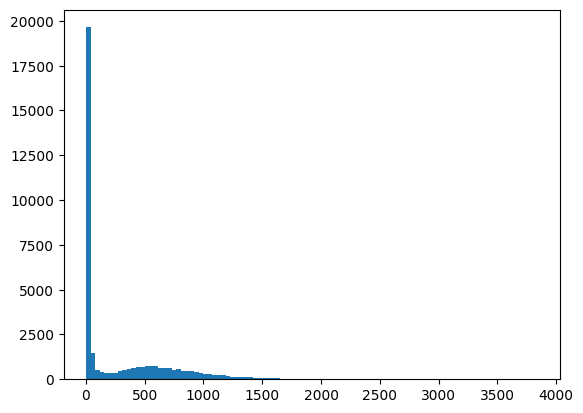

In [47]:
plt.hist(text_lengths, bins=100)

In [48]:
cloned_train_datapipe = datapipe_factory(train_datapipe, CONTEXT_SIZE)
vocab = build_vocab(cloned_train_datapipe, CONTEXT)

d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\utils\common.py:141: UserWarning: Local function is not supported by pickle, please use regular python function or functools.partial instead.
  warnings.warn(


In [49]:
VOCAB_SIZE = len(vocab)

In [50]:
# write_json_file(
#     artifact_dataset_path.joinpath("vocab.json"),
#     list(vocab.get_stoi().keys()),
# )

In [51]:
vocab.lookup_tokens(range(20))

['<unk>',
 '<bos>',
 '<eos>',
 '<pad>',
 'the',
 ',',
 '.',
 'of',
 'and',
 'in',
 'to',
 'a',
 'was',
 "'",
 '@-@',
 'on',
 'as',
 's',
 'that',
 'for']

In [52]:
text_transform = T.Sequential(
    T.VocabTransform(vocab),
    T.Truncate(CONTEXT.max_seq_len - 2),
    T.AddToken(token=CONTEXT.bos_idx, begin=True),
    T.AddToken(token=CONTEXT.eos_idx, begin=False),
    T.ToTensor(),
    T.PadTransform(CONTEXT.max_seq_len, CONTEXT.padding_idx),
)

In [53]:
train_datapipe = datapipe_factory(
    train_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

val_datapipe = datapipe_factory(
    val_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

test_datapipe = datapipe_factory(
    test_datapipe,
    CONTEXT_SIZE,
    text_transform,
)

In [54]:
NUM_WORKERS = get_num_workers()

In [55]:
train_dataloader = DataLoader(
    train_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataloader = DataLoader(
    test_datapipe,
    batch_size=BATCH_SIZE,
    pin_memory=True,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

In [56]:
for text in train_dataloader:
    print(text.shape)
    break

torch.Size([32, 256])


# model

In [57]:
EMBED_DIM = 300

In [58]:
model = RNNLM(
    RNNGenerator(
        LSTMDiscriminator(
            VOCAB_SIZE,
            EMBED_DIM,
            hidden_dim=256,
            output_size=VOCAB_SIZE,
            num_layers=2,
            bidirectional=True,
            context=CONTEXT,
        )
    ),
)

In [59]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
RNNLM                                    --
├─RNNGenerator: 1-1                      --
│    └─LSTMDiscriminator: 2-1            --
│    │    └─Embedding: 3-1               6,105,300
│    │    └─LSTM: 3-2                    2,719,744
│    │    └─LayerNorm: 3-3               1,024
│    │    └─Linear: 3-4                  10,440,063
Total params: 19,266,131
Trainable params: 19,266,131
Non-trainable params: 0

# training


In [60]:
EPOCHES = 5

In [61]:
trainer = RNNGeneratorTrainer(device=DEVICE, feature_last=True)

In [62]:
recorder = TrainRecorder(total_epoch=EPOCHES)
recorder.calc_dataset_size(map(lambda x: [[x]], train_datapipe))

0it [00:00, ?it/s]d:\research\pytorch-implementations\.venv\Lib\site-packages\torch\utils\data\datapipes\iter\combining.py:333: UserWarning: Some child DataPipes are not exhausted when __iter__ is called. We are resetting the buffer and each child DataPipe will read from the start again.
  warnings.warn("Some child DataPipes are not exhausted when __iter__ is called. We are resetting "
17456it [00:04, 3525.93it/s]


17456

In [63]:
criterion = nn.CrossEntropyLoss(
    ignore_index=CONTEXT.padding_idx,
    reduction="sum",
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [ ]:
trainer.run(
    train_dataloader,
    model,
    optimizer,
    criterion,
    scheduler=scheduler,
    recorder=recorder,
    teacher_forcing_ratio=1,
    early_stopping=False,
)

Enable AMP: False
Training...


546it [07:07,  1.28it/s]


Epoch 1 : 710.0615134794273 (0%)


546it [07:16,  1.25it/s]


Epoch 2 : 623.4801405811396 (-12%)


546it [07:19,  1.24it/s]


Epoch 3 : 582.3400032470032 (-7%)


546it [07:11,  1.27it/s]


Epoch 4 : 551.8421847922996 (-5%)


546it [07:10,  1.27it/s]


Epoch 5 : 528.0169540111563 (-4%)


546it [06:59,  1.30it/s]


Epoch 6 : 508.1458851283675 (-4%)


546it [06:37,  1.37it/s]


Epoch 7 : 489.9144587529894 (-4%)


546it [06:58,  1.30it/s]


Epoch 8 : 473.1517466572202 (-3%)


546it [06:55,  1.31it/s]


Epoch 9 : 457.6914841243696 (-3%)


546it [07:01,  1.29it/s]

Epoch 10 : 443.0229766593956 (-3%)


[710.0615134794273,
 623.4801405811396,
 582.3400032470032,
 551.8421847922996,
 528.0169540111563,
 508.1458851283675,
 489.9144587529894,
 473.1517466572202,
 457.6914841243696,
 443.0229766593956]

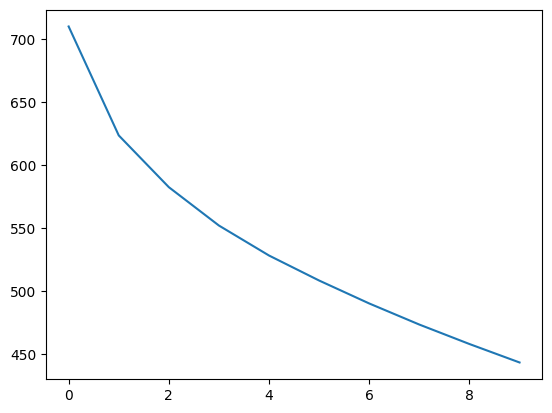

In [65]:
plt.plot(recorder.training_losses[0])

In [69]:
manager = WeightManager(artifact_path.joinpath("rnnlm.pth").as_posix())

In [70]:
model_path = manager.get_filename()
model_path

WindowsPath('../../artifacts/rnnlm/rnnlm.pth')

In [71]:
manager.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\rnnlm\rnnlm.pth, model size is 73.5MiB


In [68]:
manager.load_weight(model_path, model)

<All keys matched successfully>

# Evaluation


## predict next token

In [107]:
from torchmetrics.classification import MulticlassAccuracy
from tqdm import tqdm

In [108]:
metric = MulticlassAccuracy(VOCAB_SIZE).to(DEVICE)

In [109]:
for text in tqdm(test_dataloader):
    text = text.to(DEVICE)
    
    with torch.no_grad():
        output = model.loss_forward(text, teacher_forcing_ratio=1, early_stopping=False)
    
    output = output.argmax(-1)
    metric.update(output, text)
    # break

68it [00:22,  2.98it/s]


In [110]:
metric.compute()

tensor(0.0184, device='cuda:0')

## show embedding


In [72]:
from torchtext.vocab import Vocab

In [73]:
def sentence_to_vector(sentence: str, embedding: nn.Embedding, vocab: Vocab, device: torch.device) -> torch.Tensor:
    with torch.no_grad():
      tokens = tokenizer(sentence)
      indices = torch.LongTensor(vocab(tokens)).to(device)
      return embedding(indices)

In [74]:
sample_word_pairs = [
    ["paris", "france"],
    ["beijing", "china"],
    ["moscow", "russia"],
    ["tokyo", "japan"],
    ["athens", "greece"],
    ["rome", "italy"],
    ["berlin", "germany"],
    ["madrid", "spain"],
    ["lisbon", "portugal"],
]

In [75]:
vectors = []
for pair in sample_word_pairs:
    vectors.append(torch.cat([sentence_to_vector(item, model.head.head.foot, vocab, DEVICE) for item in pair]))

vectors = torch.cat(vectors)

In [76]:
from sklearn.decomposition import PCA

In [77]:
projector = PCA(2)
projector.fit(model.head.head.foot.weight.clone().detach().cpu())

PCA(n_components=2)

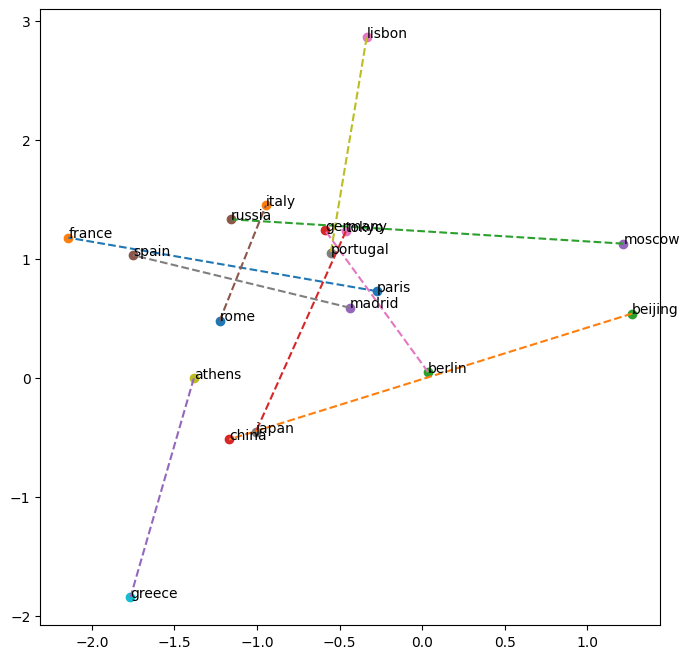

In [78]:
projected = projector.transform(vectors.detach().cpu())

plt.figure(figsize=(8,8))
for i in range(0, len(projected), 2):
    pair = sample_word_pairs[i // 2]

    plt.plot(projected[i:i+2, 0], projected[i:i+2, 1], '--')

    for j in range(2):
        x, y = projected[i+j, 0], projected[i+j, 1]
        plt.scatter(x, y)
        plt.text(x, y, pair[j])

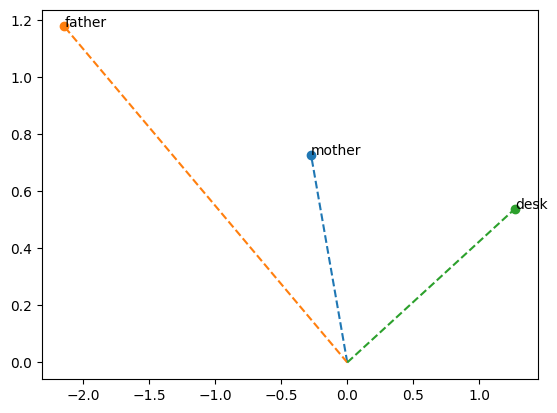

In [79]:
demo = 'mother father desk'
projected = projector.transform(vectors.detach().cpu())
for j in range(3):
  x, y = projected[j, 0], projected[j, 1]
  plt.scatter(x, y)
  plt.text(x, y, tokenizer(demo)[j])
  plt.plot(torch.Tensor([0, x]), torch.Tensor([0, y]), '--')

## word analogy


In [80]:
from torchlake.language_model.datasets import WordAnalogyDataset 

In [81]:
analogy_data_path = Path('../../data') / "word-analogy"

In [82]:
dataset = WordAnalogyDataset(analogy_data_path)

In [83]:
dataset.data[:20]

[('Athens', 'Greece', 'Baghdad', 'Iraq'),
 ('Athens', 'Greece', 'Bangkok', 'Thailand'),
 ('Athens', 'Greece', 'Beijing', 'China'),
 ('Athens', 'Greece', 'Berlin', 'Germany'),
 ('Athens', 'Greece', 'Bern', 'Switzerland'),
 ('Athens', 'Greece', 'Cairo', 'Egypt'),
 ('Athens', 'Greece', 'Canberra', 'Australia'),
 ('Athens', 'Greece', 'Hanoi', 'Vietnam'),
 ('Athens', 'Greece', 'Havana', 'Cuba'),
 ('Athens', 'Greece', 'Helsinki', 'Finland'),
 ('Athens', 'Greece', 'Islamabad', 'Pakistan'),
 ('Athens', 'Greece', 'Kabul', 'Afghanistan'),
 ('Athens', 'Greece', 'London', 'England'),
 ('Athens', 'Greece', 'Madrid', 'Spain'),
 ('Athens', 'Greece', 'Moscow', 'Russia'),
 ('Athens', 'Greece', 'Oslo', 'Norway'),
 ('Athens', 'Greece', 'Ottawa', 'Canada'),
 ('Athens', 'Greece', 'Paris', 'France'),
 ('Athens', 'Greece', 'Rome', 'Italy'),
 ('Athens', 'Greece', 'Stockholm', 'Sweden')]

In [84]:
tokens = [[vocab[word.lower()] for word in pairs] for pairs in dataset.data]
tokens[:10]

[[12958, 6970, 18304, 5313],
 [12958, 6970, 9016, 6480],
 [12958, 6970, 10275, 1346],
 [12958, 6970, 4686, 1270],
 [12958, 6970, 0, 4409],
 [12958, 6970, 14016, 2280],
 [12958, 6970, 16617, 481],
 [12958, 6970, 14322, 1572],
 [12958, 6970, 17076, 6546],
 [12958, 6970, 0, 6575]]

In [85]:
tokens = torch.LongTensor([token for token in tokens if len(token) == 4]).to(DEVICE)

In [86]:
vectors = model.head.head.foot(tokens)

In [87]:
vectors.shape

torch.Size([19544, 4, 300])

In [88]:
metric = nn.CosineSimilarity()

country_a, capital_a, country_b, capital_b = vectors.transpose(0, 1)
score = metric(country_a - capital_a - country_b, -capital_b)
print(score.mean().item())

0.08635713160037994
